# Facial Keypoint Detection
### Joe Izenman, Nabeel Siddiqi, Thong Bui

The bulk of the architectural code for our model was drawn from Daniel Nouri's tutorial, which is linked from the Kaggle competition page as a recommended starting point. We worked our way through the tutorial as written, and then experimented with a variety of tweaks and parameter adjustments.

### Package Setup & Configuration

In [23]:
%matplotlib inline

try:
    import cPickle as pickle
except ImportError:  # Python 3
    import pickle
from datetime import datetime
import os
import sys

from matplotlib import pyplot
import numpy as np
from lasagne import layers
from nolearn.lasagne import BatchIterator
from nolearn.lasagne import NeuralNet
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import theano
from scipy.ndimage.interpolation import rotate

In [24]:
sys.setrecursionlimit(10000)  # for pickle...
np.random.seed(42)

FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'
FLOOKUP = 'data/IdLookupTable.csv'

### Utility Functions

Functions for loading the data, plotting faces and results, and several functions that are used by the lasagne model.

In [25]:
def float32(k):
    return np.cast['float32'](k)


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


def load2d(test=False, cols=None):
    X, y = load(test=test, cols=cols)
    X = X.reshape(-1, 1, 96, 96)
    return X, y


def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    if y is not None:
        axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)


def plot_weights(weights):
    fig = pyplot.figure(figsize=(6, 6))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(weights[:, i].reshape(96, 96), cmap='gray')
    pyplot.show()


class FlipBatchIterator(BatchIterator):
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    ## UNCOMMENT FOR ROTATION ##
    # max_angle = 25

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]
        
        ## UNCOMMENT FOR ROTATION
        # Rotate 1/4 of the images (reflected or not) a random amount, up to 20 degrees
        # indices2 = np.random.choice(bs, bs / 4, replace=False)
        # angle = np.random.randint(-1*self.max_angle, self.max_angle)
        # Xb[indices2] = rotate(Xb[indices2], angle=angle, reshape=False, mode="nearest", axes=(2,3))


        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

                ## UNCOMMENT FOR ROTATION
                # Loop over faces to rotate and rotate the labels as well
                # for i in indices2:
                #     yb[i] = rotate_points(yb[i], angle)
                    
        return Xb, yb


class AdjustVariable(object):
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


class EarlyStopping(object):
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

## JOE'S FUNCTIONS FOR ROTATION ##

# Convert a 1D vector of labels values to a 2D array of X,Y pairs
def points_1d_to_2d(points):
    return np.reshape(np.array(points), (-1,2))

# Convert a 2D array of X,Y pairs back to a 1D vector of labels
def points_2d_to_1d(points):
    return np.reshape(np.array(points), -1)

# Return values of the label array to match a rotated version of the image.
def rotate_points(yb, angle):
    tmp = points_1d_to_2d(yb)
    
    theta = -1*np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    
    return points_2d_to_1d(R.dot(tmp.T).T)

### Base Model

This model is built on all 15 points simultaneously, using only complete cases that have all 30 labels. Once the model is trained, it is saved for use initializing the specialist models. The initial run, shown here, uses three convolution/pooling pairs and two hidden layers, and leverages dropout, early stopping, and learning rate momentum adjustment. It also generates additional learning variation by randomly selecting some images to flip horizontally during each epoch.

In [27]:
net = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('dropout3', layers.DropoutLayer),
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    dropout1_p=0.1,
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    dropout2_p=0.2,
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    dropout3_p=0.3,
    hidden4_num_units=1000,
    dropout4_p=0.5,
    hidden5_num_units=1000,
    output_num_units=30, output_nonlinearity=None,

    update_learning_rate=theano.shared(float32(0.03)),
    update_momentum=theano.shared(float32(0.9)),

    regression=True,
    batch_iterator_train=FlipBatchIterator(batch_size=128),
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.03, stop=0.0001),
        AdjustVariable('update_momentum', start=0.9, stop=0.999),
        EarlyStopping(patience=200),
        ],
    max_epochs=3000,
    verbose=1,
    )


def fit():
    X, y = load2d()
    net.fit(X, y)
    with open('net.pickle', 'wb') as f:
        pickle.dump(net, f, -1)

In [28]:
fit()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## Base Model Tuning

We tried several variations on this original model. Rather than running them all here, we will load from their pickle files and compare.

In [83]:
def analyze_single_model(fname_specialists):
    with open(fname_specialists, 'rb') as f:
        saved_net = pickle.load(f)
    
    train_loss = np.array([i["train_loss"] for i in saved_net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in saved_net.train_history_])
    pyplot.plot(train_loss, linewidth=3, label="train")
    pyplot.plot(valid_loss, linewidth=3, label="valid")
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(7e-4, 7e-2)
    pyplot.yscale("log")
    pyplot.show()
    
    best_epoch = min(saved_net.train_history_, key=lambda x:x['valid_loss'])
    
    print "Best Epoch: %s" % best_epoch['epoch']
    print "Training Loss: %s" % best_epoch['train_loss']
    print "Validation Loss: %s" % best_epoch['valid_loss']
    print "Training/Validation %s" % (best_epoch['train_loss'] / best_epoch['valid_loss'])

### Base Model (Max Epochs: 10000)

This is the same model as above, but run for a maximum 10,000 epochs (it did hit early stopping around 9000).

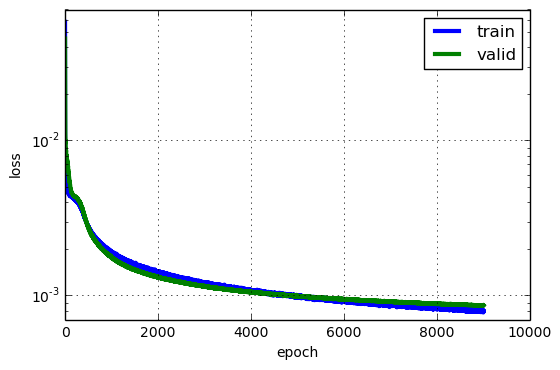

Best Epoch: 8803
Training Loss: 0.000803833431347
Validation Loss: 0.000858459138055
Training/Validation 0.936367726446


In [84]:
analyze_single_model("pickles/net-base.pickle")

### Adding Layers

In these models, a fourth convolution/pooling pair was added, followed by a hidden layer. In both cases the model leveled off extremely quickly, with a much worse result than the previous architecture.

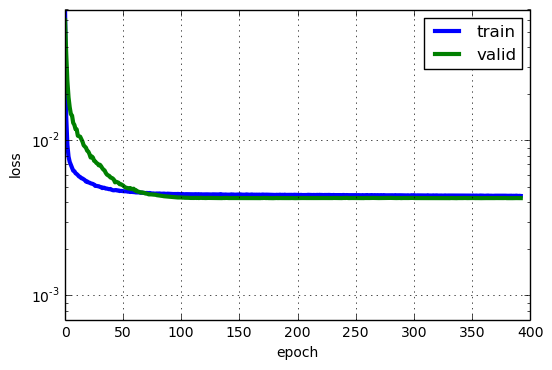

Best Epoch: 192
Training Loss: 0.00445714292647
Validation Loss: 0.00424562599162
Training/Validation 1.04981996419


In [85]:
analyze_single_model("pickles/net-add-convpool.pickle")

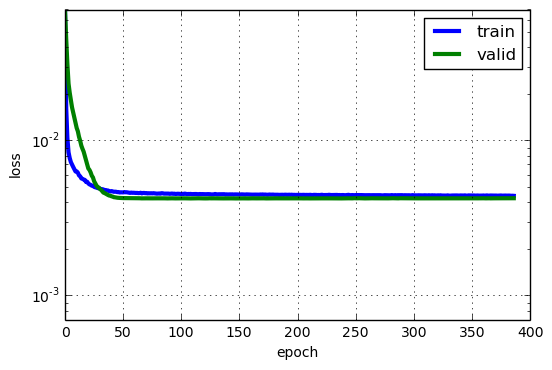

Best Epoch: 186
Training Loss: 0.0044613508203
Validation Loss: 0.00422572630901
Training/Validation 1.05575952962


In [86]:
analyze_single_model("pickles/net-add-convpool-add-hidden.pickle")

### Base Model With Rotation

In this model, we built upon the BatchFlipIterator, to also perform random rotation on a quarter of all examples, in order to produce more training example variability. This produces much noisier lines, and stops early, and doesn't result in as strong a model as the original.

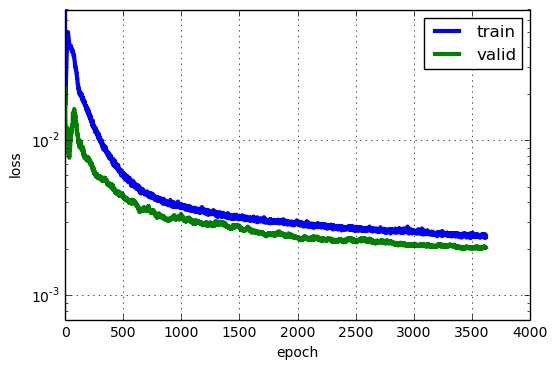

Best Epoch: 3419
Training Loss: 0.00243015161924
Validation Loss: 0.00199646548755
Training/Validation 1.21722696154


In [87]:
analyze_single_model("pickles/net-base-with-rotation.pickle")

### Specialist Models

To integrate all the data, separate models are trained. The points are split into groups that appear in the same set of images.

In [32]:
from collections import OrderedDict

from sklearn.base import clone


SPECIALIST_SETTINGS = [
    dict(
        columns=(
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x', 'right_eye_center_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'nose_tip_x', 'nose_tip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            ),
        flip_indices=((0, 2), (1, 3)),
        ),

    dict(
        columns=(
            'mouth_center_bottom_lip_x',
            'mouth_center_bottom_lip_y',
            ),
        flip_indices=(),
        ),

    dict(
        columns=(
            'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
            'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
            'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
            'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),

    dict(
        columns=(
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            ),
        flip_indices=((0, 2), (1, 3), (4, 6), (5, 7)),
        ),
    ]

In [33]:
def fit_specialists(fname_pretrain=None):
    if fname_pretrain:
        with open(fname_pretrain, 'rb') as f:
            net_pretrain = pickle.load(f)
    else:
        net_pretrain = None

    specialists = OrderedDict()

    for setting in SPECIALIST_SETTINGS:
        cols = setting['columns']
        X, y = load2d(cols=cols)

        model = clone(net)
        model.output_num_units = y.shape[1]
        model.batch_iterator_train.flip_indices = setting['flip_indices']
        model.max_epochs = int(4e6 / y.shape[0])
        if 'kwargs' in setting:
            # an option 'kwargs' in the settings list may be used to
            # set any other parameter of the net:
            vars(model).update(setting['kwargs'])

        if net_pretrain is not None:
            # if a pretrain model was given, use it to initialize the
            # weights of our new specialist model:
            model.load_params_from(net_pretrain)

        print("Training model for columns {} for {} epochs".format(
            cols, model.max_epochs))
        model.fit(X, y)
        specialists[cols] = model

    with open('net-specialists.pickle', 'wb') as f:
        # this time we're persisting a dictionary with all models:
        pickle.dump(specialists, f, -1)

In [ ]:
fit_specialists("net.pickle")

left_eye_center_x     7039
left_eye_center_y     7039
right_eye_center_x    7036
right_eye_center_y    7036
Image                 7049
dtype: int64


/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Could not load parameters to layer 'output' because shapes did not match: 1000x4 vs 1000x30.
Could not load parameters to layer 'output' because shapes did not match: 4 vs 30.
Training model for columns ('left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y') for 568 epochs
# Neural Network with 16535476 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool

/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:122: DeprecationWarning: Estimator NeuralNet modifies parameters in __init__. This behavior is deprecated as of 0.

Loaded parameters to layer 'conv1' (shape 32x1x3x3).
Loaded parameters to layer 'conv1' (shape 32).
Loaded parameters to layer 'conv2' (shape 64x32x2x2).
Loaded parameters to layer 'conv2' (shape 64).
Loaded parameters to layer 'conv3' (shape 128x64x2x2).
Loaded parameters to layer 'conv3' (shape 128).
Loaded parameters to layer 'hidden4' (shape 15488x1000).
Loaded parameters to layer 'hidden4' (shape 1000).
Loaded parameters to layer 'hidden5' (shape 1000x1000).
Loaded parameters to layer 'hidden5' (shape 1000).
Could not load parameters to layer 'output' because shapes did not match: 1000x2 vs 1000x30.
Could not load parameters to layer 'output' because shapes did not match: 2 vs 30.
Training model for columns ('nose_tip_x', 'nose_tip_y') for 567 epochs
# Neural Network with 16533474 learnable parameters

## Layer information

  #  name      size
---  --------  ---------
  0  input     1x96x96
  1  conv1     32x94x94
  2  pool1     32x47x47
  3  dropout1  32x47x47
  4  conv2     64x4

### Analysis

These functions generate predictions on the test data, and will plot the statistics for the specialist models.

In [60]:
def predict(fname_specialists='net-specialists.pickle'):
    with open(fname_specialists, 'rb') as f:
        specialists = pickle.load(f)

    X = load2d(test=True)[0]
    y_pred = np.empty((X.shape[0], 0))

    for model in specialists.values():
        y_pred1 = model.predict(X)
        y_pred = np.hstack([y_pred, y_pred1])

    columns = ()
    for cols in specialists.keys():
        columns += cols

    y_pred2 = y_pred * 48 + 48
    y_pred2 = y_pred2.clip(0, 96)
    df = DataFrame(y_pred2, columns=columns)

    lookup_table = read_csv(os.path.expanduser(FLOOKUP))
    values = []

    for index, row in lookup_table.iterrows():
        values.append((
            row['RowId'],
            df.ix[row.ImageId - 1][row.FeatureName],
            ))

    now_str = datetime.now().isoformat().replace(':', '-')
    submission = DataFrame(values, columns=('RowId', 'Location'))
    filename = 'submission-{}.csv'.format(now_str)
    submission.to_csv(filename, index=False)
    print("Wrote {}".format(filename))


def rebin( a, newshape ):
    from numpy import mgrid
    assert len(a.shape) == len(newshape)

    slices = [ slice(0,old, float(old)/new) for old,new in zip(a.shape,newshape) ]
    coordinates = mgrid[slices]
    indices = coordinates.astype('i')   #choose the biggest smaller integer index
    return a[tuple(indices)]


def plot_learning_curves(fname_specialists='net-specialists.pickle'):
    with open(fname_specialists, 'rb') as f:
        models = pickle.load(f)

    fig = pyplot.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_color_cycle(
        ['c', 'c', 'm', 'm', 'y', 'y', 'k', 'k', 'g', 'g', 'b', 'b'])

    valid_losses = []
    train_losses = []

    for model_number, (cg, model) in enumerate(models.items(), 1):
        valid_loss = np.array([i['valid_loss'] for i in model.train_history_])
        train_loss = np.array([i['train_loss'] for i in model.train_history_])
        valid_loss = np.sqrt(valid_loss) * 48
        train_loss = np.sqrt(train_loss) * 48

        valid_loss = rebin(valid_loss, (100,))
        train_loss = rebin(train_loss, (100,))

        valid_losses.append(valid_loss)
        train_losses.append(train_loss)
        ax.plot(valid_loss,
                label='{} ({})'.format(cg[0], len(cg)), linewidth=3)
        ax.plot(train_loss,
                linestyle='--', linewidth=3, alpha=0.6)
        ax.set_xticks([])

    weights = np.array([m.output_num_units for m in models.values()],
                       dtype=float)
    weights /= weights.sum()
    mean_valid_loss = (
        np.vstack(valid_losses) * weights.reshape(-1, 1)).sum(axis=0)
    ax.plot(mean_valid_loss, color='r', label='mean', linewidth=4, alpha=0.8)

    ax.legend()
    ax.set_ylim((1.0, 4.5))
    ax.grid()
    pyplot.ylabel("RMSE")
    pyplot.show()

### Specialists: Original

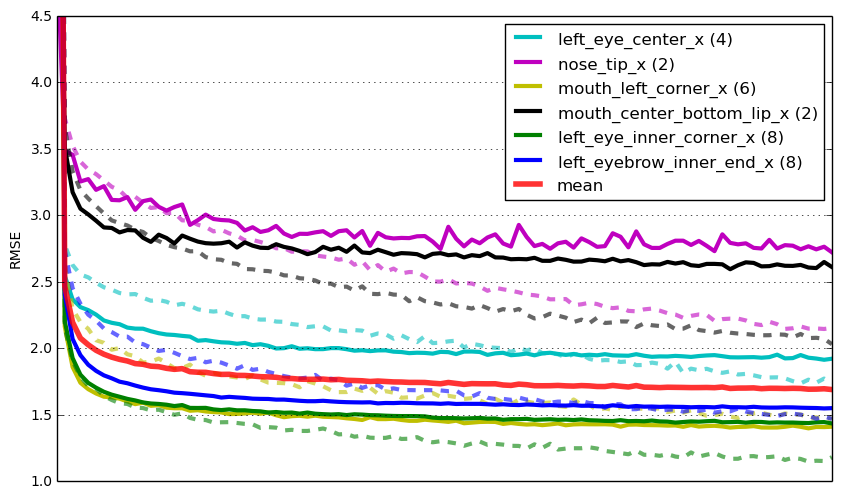

In [61]:
plot_learning_curves(fname_specialists="pickles/net-specialists-base.pickle")

### Specialists: Dropout Adjusted

A few of the models show a wide difference opening up between training and validation loss (particularly the purple and black lines), indicating there may be danger of overfitting when applying the model to an unseen test set. Additionally, the blue and yellow lines land close enough to suggest that they don't need as much dropout as was used. For the final model, we adjusted the dropout levels levels up and down based on the above plot.

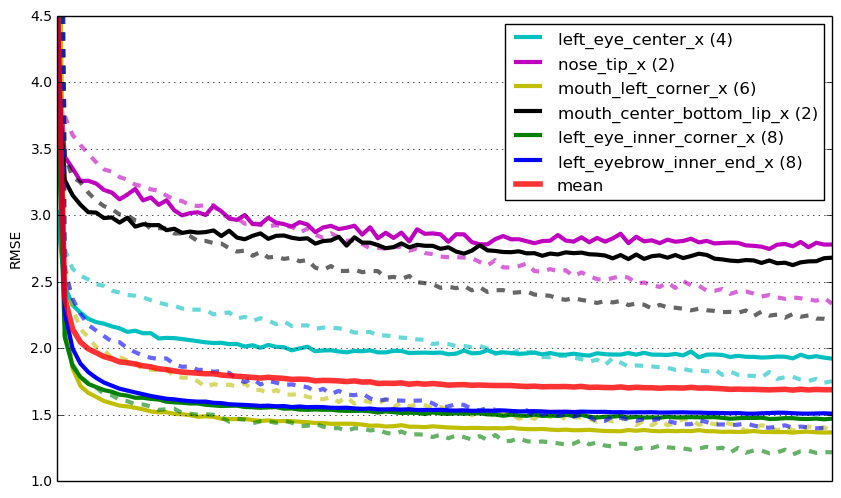

In [62]:
plot_learning_curves(fname_specialists="pickles/net-specialists-adjusted.pickle")

In [89]:
predict("pickles/net-specialists-adjusted.pickle")

ImageId    1783
Image      1783
dtype: int64
Wrote submission-2017-04-22T23-29-49.719057.csv


In [90]:
predict("pickles/net-specialists-base.pickle")

ImageId    1783
Image      1783
dtype: int64
Wrote submission-2017-04-22T23-33-51.449180.csv


Ultimately, the adjusted model performed slightly worse in kaggle's metric, 2.16566 vs 2.15080.